Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 207 rows, 200 columns and 900 nonzeros
Model fingerprint: 0xbe51a2bd
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [5e-02, 3e+02]
  Objective range  [2e-02, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 2e+02]
Presolve removed 204 rows and 100 columns
Presolve time: 0.00s
Presolved: 3 rows, 100 columns, 298 nonzeros
Variable types: 100 continuous, 0 integer (0 binary)

Root relaxation: objective 5.477600e-01, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.547760

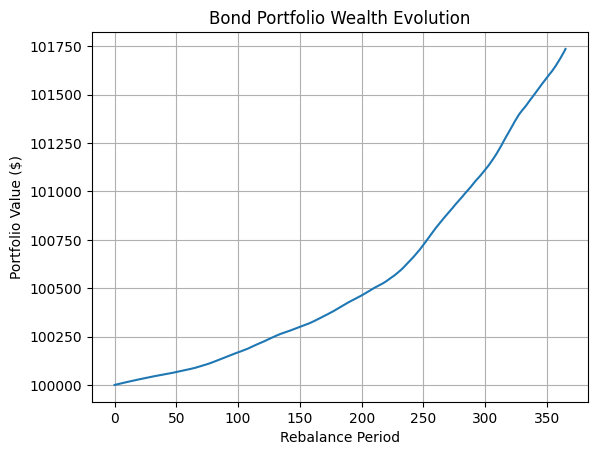

[[100000.     ]
 [100001.42776]
 [100002.98633]
 [100004.58808]
 [100006.05236]
 [100007.52227]
 [100008.96791]
 [100010.33332]
 [100011.8303 ]
 [100013.36686]
 [100014.86284]
 [100016.33535]
 [100017.79793]
 [100019.36159]
 [100020.81968]
 [100022.27493]
 [100023.702  ]
 [100025.06661]
 [100026.392  ]
 [100027.68504]
 [100029.00223]
 [100030.35582]
 [100031.748  ]
 [100033.06477]
 [100034.42071]
 [100035.76496]
 [100037.12146]
 [100038.4726 ]
 [100039.78222]
 [100041.04965]
 [100042.27036]
 [100043.5249 ]
 [100044.76452]
 [100045.92308]
 [100047.07001]
 [100048.12734]
 [100049.2563 ]
 [100050.37114]
 [100051.4071 ]
 [100052.51731]
 [100053.64125]
 [100054.87277]
 [100056.20043]
 [100057.56216]
 [100058.8084 ]
 [100060.08211]
 [100061.34206]
 [100062.6427 ]
 [100063.92083]
 [100065.33142]
 [100066.80994]
 [100068.26571]
 [100069.57742]
 [100070.91127]
 [100072.27226]
 [100073.66769]
 [100074.9962 ]
 [100076.42182]
 [100077.86174]
 [100079.21218]
 [100080.51554]
 [100081.91628]
 [100083

<Figure size 640x480 with 0 Axes>

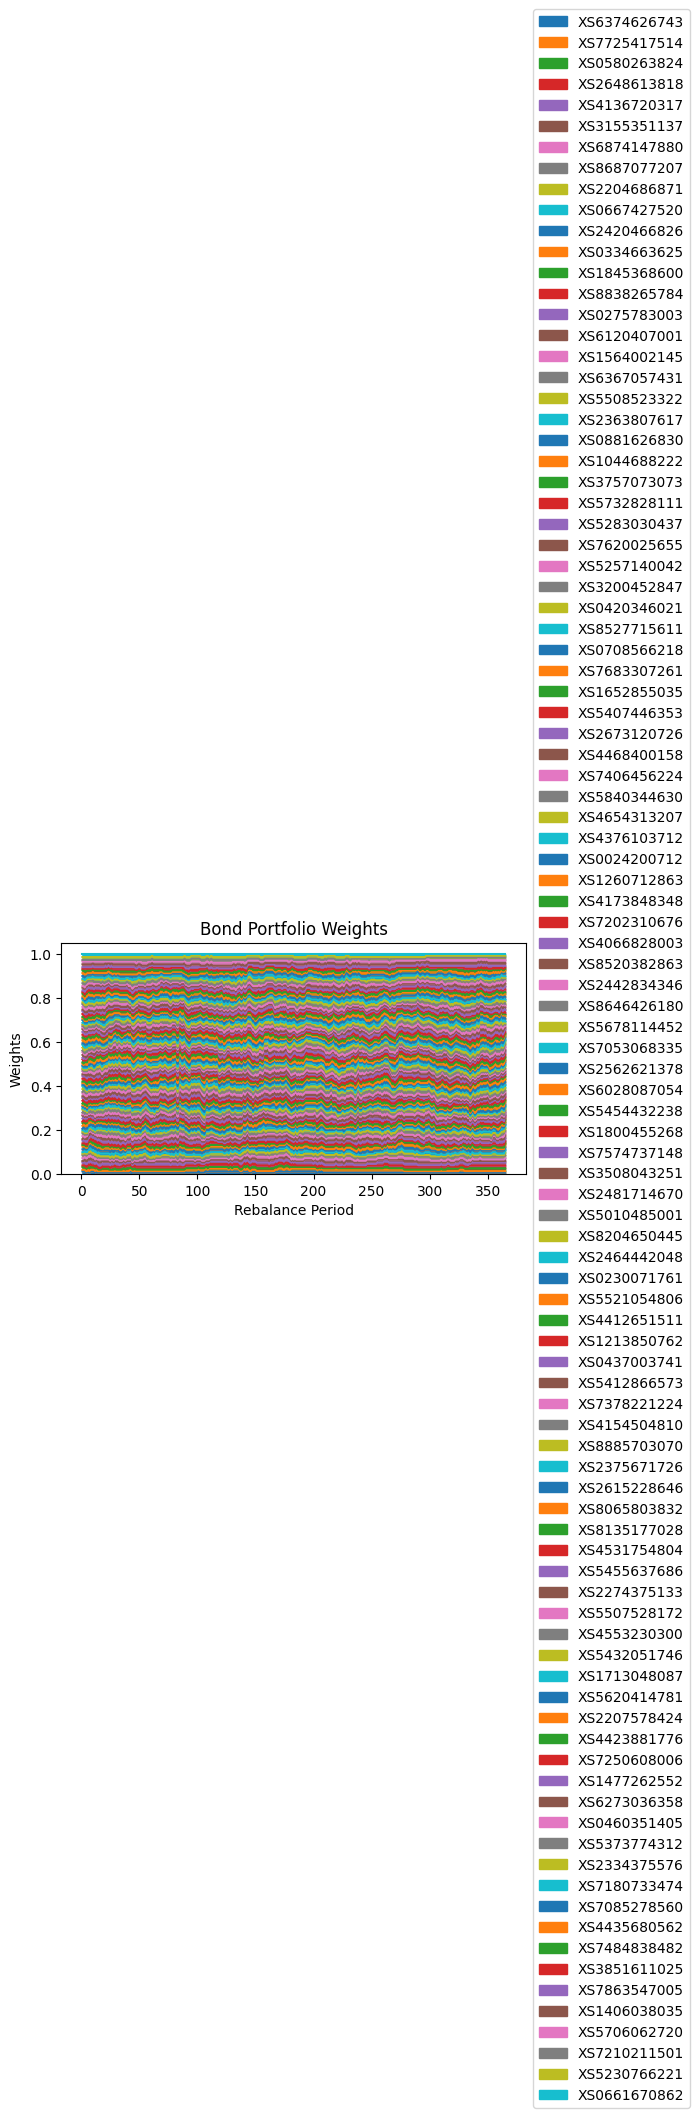

In [23]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
from scipy.stats import gmean
from scipy.optimize import linprog
import matplotlib.pyplot as plt


pd.set_option('mode.chained_assignment', None)

bond_data = pd.read_csv(r'C:\Users\Melanie\Desktop\optimization_engine\bond_data.csv')
bond_data['Date'] = pd.to_datetime(bond_data['Date'])

# Initial budget to invest ($100,000)
initialVal = 100000  

# Length of investment period (in months)
investPeriod = 1

#Identify the tickers and the dates
tickers = bond_data['ISIN'].unique()
dates = bond_data['Date'].unique()

n = len(tickers)   # Number of bonds
NoPeriods = len(dates) // investPeriod  
# Preallocate space for portfolio weights (x0 will track turnover)
x = np.zeros([n, NoPeriods])
x0 = np.zeros([n, NoPeriods])

# Preallocate space for portfolio value and turnover
currentVal = np.zeros([NoPeriods + 1, 1])
currentVal[0] = initialVal
portfolio_returns = np.zeros(NoPeriods)
turnover = np.zeros([NoPeriods, 1])

rf = 0.02/365

# Iterate through investment periods
for period in range(NoPeriods):
    # Select bonds available during this period
    current_bonds = bond_data[bond_data['Date'] == dates[period * investPeriod]]

    #placeholder
    weights = MIP(current_bonds, 1)
    
    # Store weights
    x[:, period] = weights
    
    # Calculate expected portfolio return and risk based on the bonds
    portfolio_return = np.sum(weights * current_bonds['expected_return'])  # Check this value
    #print("portfolio_return: ", portfolio_return)
    portfolio_risk = np.sqrt(np.sum((weights**2) * (current_bonds['return_std_dev']**2)))
    
    # Simulate the portfolio value evolution
    currentVal[period + 1] = currentVal[period] + (portfolio_return)
    
    portfolio_returns[period] = portfolio_return

    # Calculate turnover (assume full rebalance between periods)
    turnover[period] = np.sum(np.abs(weights - x0[:, period])) / 2
    x0[:, period] = weights

    print("OAS values for bonds for this iteration:")
    print(current_bonds['OAS'].values)

    print("weights: ", weights)
    
    weighted_OAS = np.sum(weights*current_bonds['OAS'])
    print(f"Weighted OAS for the optimized portfolio: {weighted_OAS}")



excess_returns = portfolio_returns - rf

print(excess_returns.shape)
SR = (gmean(excess_returns + 1) - 1)/excess_returns.std()

avgTurnover = np.mean(turnover[1:])
print('Sharpe ratio: ', str(SR))
print('Avg. turnover: ', str(avgTurnover))

# --------------------------------------------------------------------------
# 3.1 Plot portfolio wealth evolution
# --------------------------------------------------------------------------
plt.figure(1)
plt.plot(np.arange(0, NoPeriods + 1), currentVal, label='Portfolio Value')
plt.title('Bond Portfolio Wealth Evolution')
plt.xlabel('Rebalance Period')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.savefig("bond_wealth_evolution.png")
plt.show()
print(currentVal)
# --------------------------------------------------------------------------
# 3.2 Plot portfolio weights per rebalance period
# --------------------------------------------------------------------------
fig2 = plt.figure(2)
x[x < 0] = 0
weights = pd.DataFrame(x[(x > 0).any(axis=1)], index=tickers[(x > 0).any(axis=1)])
weights.columns = [col + 1 for col in weights.columns]
weights.T.plot.area(title='Bond Portfolio Weights',
                    ylabel='Weights',
                    xlabel='Rebalance Period',
                    figsize=(6, 3),
                    legend=True,
                    stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig("bond_weights.png")
plt.show()

In [21]:
def MIP(bond_data, lambda_penalty):
    # Create the model
    N = len(bond_data)  # Number of bonds based on the DataFrame length
    W_max = 1.0  # Maximum weight for the portfolio

    # Calculate additional fields
    bond_data['DTS'] = bond_data['duration'] * bond_data['OAS']
    bond_data['transaction_cost'] = bond_data['ask_price'] - bond_data['bid_price']
    bond_data['OAS'] = pd.to_numeric(bond_data['OAS'], errors='coerce')
    expected_return = np.array(bond_data['expected_return'])

    # Create the model
    model = gp.Model("MIP")

    # Decision variables
    w = model.addVars(N, vtype=GRB.CONTINUOUS, lb=0, name="w")  # weights for bonds
    x = model.addVars(N, vtype=GRB.BINARY, name="x")  # binary selection of bonds

    # Constrain the total weight
    model.addConstr(gp.quicksum(w[i] for i in range(N)) <= W_max, "MaxWeight")
    model.addConstr(gp.quicksum(w[i] for i in range(N)) == 1, "WeightSum")

    # Set the objective: 
    model.setObjective(
    gp.quicksum((expected_return[i] * w[i] - bond_data.iloc[i]['transaction_cost'] * x[i]) for i in range(N)),  # return minus transaction cost
    # - lambda_penalty * gp.quicksum(bond_data.loc[i, 'OAS'] * w[i] for i in range(N))  # OAS risk term
    # - lambda_penalty * gp.quicksum(bond_data.loc[i, 'DTS'] * w[i] for i in range(N)),  # DTS risk term
    GRB.MAXIMIZE
    )

    # Deviation from benchmark
    deviation_limit = 0.3  # 10% deviation
    BenchmarkWeight = 0.01  # 1% in each bond

    for i in range(N):
        model.addConstr(w[i] >= BenchmarkWeight - deviation_limit*BenchmarkWeight)
        model.addConstr(w[i] <= BenchmarkWeight + deviation_limit*BenchmarkWeight)

    # # binary 
    # for i in range(N):
    #     model.addConstr(w[i] <= x[i], f"WeightSelection_{i}")

    # OAS Constraints
    weighted_OAS = gp.quicksum(bond_data.iloc[i]['OAS'] * w[i] for i in range(N))
    benchmark_OAS = sum(0.01 * bond_data.iloc[i]['OAS'] for i in range(N))  # 1% in each bond
    lower_bound = 0.9 * benchmark_OAS
    upper_bound = 1.1 * benchmark_OAS

    model.addConstr(weighted_OAS >= lower_bound, name="OAS_LowerBound")
    model.addConstr(weighted_OAS <= upper_bound, name="OAS_UpperBound")


    # Liquidity Constraint
    Liquidity = gp.quicksum(bond_data.iloc[i]['liquidity_score'] for i in range(N)) / N
    MinLiquidity = 0.9 * Liquidity
    model.addConstr(gp.quicksum(bond_data.iloc[i]['liquidity_score'] * w[i] for i in range(N)) >= MinLiquidity, "MinLiquidity")

    # Transaction Cost Constraints
    Benchmark_cost = gp.quicksum(bond_data.iloc[i]['transaction_cost'] for i in range(N)) / N
    lower_t_cost = 0.9 * Benchmark_cost
    upper_t_cost = 1.1 * Benchmark_cost

    model.addConstr(gp.quicksum(bond_data.iloc[i]['transaction_cost'] * x[i] for i in range(N)) >= lower_t_cost, "MinTCost")
    model.addConstr(gp.quicksum(bond_data.iloc[i]['transaction_cost'] * x[i] for i in range(N)) <= upper_t_cost, "MaxTCost")

    # Optimize the model
    model.optimize()

    if model.status == GRB.OPTIMAL:
        #print("Optimal solution found. List of all weights:")
        weights = [w[i].X for i in range(N)]  # Get the optimized weights for bonds
        return np.array(weights)

    if model.status == GRB.INFEASIBLE:
        print("The model is infeasible.")
    
    